In [7]:
# Unless otherwise stated the Author is Rene Pickhardt and the license is GPLv3

# change the directory in which you are working / in which your mails are stored
directory = "/Users/rpickhardt/dncmail/"

In [8]:
# this code block is via: https://github.com/aspineux/pyzmail (LGPL)
# and: http://blog.magiksys.net/parsing-email-using-python-content

import sys, os, re, StringIO
import email, mimetypes

invalid_chars_in_filename='<>:"/\\|?*\%\''+reduce(lambda x,y:x+chr(y), range(32), '')
invalid_windows_name='CON PRN AUX NUL COM1 COM2 COM3 COM4 COM5 COM6 COM7 COM8 COM9 LPT1 LPT2 LPT3 LPT4 LPT5 LPT6 LPT7 LPT8 LPT9'.split()

# email address REGEX matching the RFC 2822 spec from perlfaq9
#    my $atom       = qr{[a-zA-Z0-9_!#\$\%&'*+/=?\^`{}~|\-]+};
#    my $dot_atom   = qr{$atom(?:\.$atom)*};
#    my $quoted     = qr{"(?:\\[^\r\n]|[^\\"])*"};
#    my $local      = qr{(?:$dot_atom|$quoted)};
#    my $domain_lit = qr{\[(?:\\\S|[\x21-\x5a\x5e-\x7e])*\]};
#    my $domain     = qr{(?:$dot_atom|$domain_lit)};
#    my $addr_spec  = qr{$local\@$domain};
# 
# Python's translation

atom_rfc2822=r"[a-zA-Z0-9_!#\$\%&'*+/=?\^`{}~|\-]+"
atom_posfix_restricted=r"[a-zA-Z0-9_#\$&'*+/=?\^`{}~|\-]+" # without '!' and '%'
atom=atom_rfc2822
dot_atom=atom  +  r"(?:\."  +  atom  +  ")*"
quoted=r'"(?:\\[^\r\n]|[^\\"])*"'
local="(?:"  +  dot_atom  +  "|"  +  quoted  +  ")"
domain_lit=r"\[(?:\\\S|[\x21-\x5a\x5e-\x7e])*\]"
domain="(?:"  +  dot_atom  +  "|"  +  domain_lit  +  ")"
addr_spec=local  +  "\@"  +  domain

email_address_re=re.compile('^'+addr_spec+'$')

class Attachment:
    def __init__(self, part, filename=None, type=None, payload=None, charset=None, content_id=None, description=None, disposition=None, sanitized_filename=None, is_body=None):
        self.part=part          # original python part
        self.filename=filename  # filename in unicode (if any) 
        self.type=type          # the mime-type
        self.payload=payload    # the MIME decoded content 
        self.charset=charset    # the charset (if any) 
        self.description=description    # if any 
        self.disposition=disposition    # 'inline', 'attachment' or None
        self.sanitized_filename=sanitized_filename # cleanup your filename here (TODO)  
        self.is_body=is_body        # usually in (None, 'text/plain' or 'text/html')
        self.content_id=content_id  # if any
        if self.content_id:
            # strip '<>' to ease searche and replace in "root" content (TODO) 
            if self.content_id.startswith('<') and self.content_id.endswith('>'):
                self.content_id=self.content_id[1:-1]

def getmailheader(header_text, default="ascii"):
    """Decode header_text if needed"""
    try:
        headers=email.Header.decode_header(header_text)
    except email.Errors.HeaderParseError:
        # This already append in email.base64mime.decode()
        # instead return a sanitized ascii string
        # this faile '=?UTF-8?B?15HXmdeh15jXqNeVINeY15DXpteUINeTJ9eV16jXlSDXkdeg15XXldeUINem15PXpywg15TXptei16bXldei15nXnSDXqdecINek15zXmdeZ?==?UTF-8?B?157XldeR15nXnCwg157Xldek16Ig157Xl9eV15wg15HXodeV15bXnyDXk9ec15DXnCDXldeh15gg157Xl9eR16rXldeqINep15wg15HXmdeQ?==?UTF-8?B?15zXmNeZ?='
        return header_text.encode('ascii', 'replace').decode('ascii')
    else:
        for i, (text, charset) in enumerate(headers):
            try:
                headers[i]=unicode(text, charset or default, errors='replace')
            except LookupError:
                # if the charset is unknown, force default 
                headers[i]=unicode(text, default, errors='replace')
        return u"".join(headers)

def getmailaddresses(msg, name):
    """retrieve addresses from header, 'name' supposed to be from, to,  ..."""
    addrs=email.utils.getaddresses(msg.get_all(name, []))
    for i, (name, addr) in enumerate(addrs):
        if not name and addr:
            # only one string! Is it the address or is it the name ?
            # use the same for both and see later
            name=addr
            
        try:
            # address must be ascii only
            addr=addr.encode('ascii')
        except UnicodeError:
            addr=''
        else:
            # address must match address regex
            if not email_address_re.match(addr):
                addr=''
        addrs[i]=(getmailheader(name), addr)
    return addrs

def get_filename(part):
    """Many mail user agents send attachments with the filename in 
    the 'name' parameter of the 'content-type' header instead 
    of in the 'filename' parameter of the 'content-disposition' header.
    """
    filename=part.get_param('filename', None, 'content-disposition')
    if not filename:
        filename=part.get_param('name', None) # default is 'content-type'
        
    if filename:
        # RFC 2231 must be used to encode parameters inside MIME header
        filename=email.Utils.collapse_rfc2231_value(filename).strip()

    if filename and isinstance(filename, str):
        # But a lot of MUA erroneously use RFC 2047 instead of RFC 2231
        # in fact anybody miss use RFC2047 here !!!
        filename=getmailheader(filename)
        
    return filename

def _search_message_bodies(bodies, part):
    """recursive search of the multiple version of the 'message' inside 
    the the message structure of the email, used by search_message_bodies()"""
    
    type=part.get_content_type()
    if type.startswith('multipart/'):
        # explore only True 'multipart/*' 
        # because 'messages/rfc822' are also python 'multipart' 
        if type=='multipart/related':
            # the first part or the one pointed by start 
            start=part.get_param('start', None)
            related_type=part.get_param('type', None)
            for i, subpart in enumerate(part.get_payload()):
                if (not start and i==0) or (start and start==subpart.get('Content-Id')):
                    _search_message_bodies(bodies, subpart)
                    return
        elif type=='multipart/alternative':
            # all parts are candidates and latest is best
            for subpart in part.get_payload():
                _search_message_bodies(bodies, subpart)
        elif type in ('multipart/report',  'multipart/signed'):
            # only the first part is candidate
            try:
                subpart=part.get_payload()[0]
            except IndexError:
                return
            else:
                _search_message_bodies(bodies, subpart)
                return

        elif type=='multipart/signed':
            # cannot handle this
            return
            
        else: 
            # unknown types must be handled as 'multipart/mixed'
            # This is the peace of code could probably be improved, I use a heuristic : 
            # - if not already found, use first valid non 'attachment' parts found
            for subpart in part.get_payload():
                tmp_bodies=dict()
                _search_message_bodies(tmp_bodies, subpart)
                for k, v in tmp_bodies.iteritems():
                    if not subpart.get_param('attachment', None, 'content-disposition')=='':
                        # if not an attachment, initiate value if not already found
                        bodies.setdefault(k, v)
            return
    else:
        bodies[part.get_content_type().lower()]=part
        return
    
    return

def search_message_bodies(mail):
    """search message content into a mail"""
    bodies=dict()
    _search_message_bodies(bodies, mail)
    return bodies

def get_mail_contents(msg):
    """split an email in a list of attachments"""

    attachments=[]

    # retrieve messages of the email
    bodies=search_message_bodies(msg)
    # reverse bodies dict
    parts=dict((v,k) for k, v in bodies.iteritems())

    # organize the stack to handle deep first search
    stack=[ msg, ]
    while stack:
        part=stack.pop(0)
        type=part.get_content_type()
        if type.startswith('message/'): 
            # ('message/delivery-status', 'message/rfc822', 'message/disposition-notification'):
            # I don't want to explore the tree deeper her and just save source using msg.as_string()
            # but I don't use msg.as_string() because I want to use mangle_from_=False 
            from email.Generator import Generator
            fp = StringIO.StringIO()
            g = Generator(fp, mangle_from_=False)
            g.flatten(part, unixfrom=False)
            payload=fp.getvalue()
            filename='mail.eml'
            attachments.append(Attachment(part, filename=filename, type=type, payload=payload, charset=part.get_param('charset'), description=part.get('Content-Description')))
        elif part.is_multipart():
            # insert new parts at the beginning of the stack (deep first search)
            stack[:0]=part.get_payload()
        else:
            payload=part.get_payload(decode=True)
            charset=part.get_param('charset')
            filename=get_filename(part)
                
            disposition=None
            if part.get_param('inline', None, 'content-disposition')=='':
                disposition='inline'
            elif part.get_param('attachment', None, 'content-disposition')=='':
                disposition='attachment'
                
            attachments.append(Attachment(part, filename=filename, type=type, payload=payload, charset=charset, content_id=part.get('Content-Id'), description=part.get('Content-Description'), disposition=disposition, is_body=parts.get(part)))

    return attachments

def decode_text(payload, charset, default_charset):
    if charset:
        try: 
            return payload.decode(charset), charset
        except UnicodeError:
            pass

    if default_charset and default_charset!='auto':
        try: 
            return payload.decode(default_charset), default_charset
        except UnicodeError:
            pass
        
    for chset in [ 'ascii', 'utf-8', 'utf-16', 'windows-1252', 'cp850' ]:
        try: 
            return payload.decode(chset), chset
        except UnicodeError:
            pass

    return payload, None


def getMail(raw):
    d = {}
    msg=email.message_from_string(raw)
    attachments=get_mail_contents(msg)
 
    subject=getmailheader(msg.get('Subject', ''))
    from_=getmailaddresses(msg, 'from')
    from_=('', '') if not from_ else from_[0]
    tos=getmailaddresses(msg, 'to')
        
    d["S"]=subject
    d["F"]=(from_,)
    d["T"]=(tos,)
    sendDate = msg.get('Date','')[5:-6]
#    print sendDate
    ts = "-1"
    try:
        ts = int(time.mktime(time.strptime(sendDate,"%d %b %Y %H:%M:%S")))
    except:
        try: 
            ts = int(time.mktime(time.strptime(sendDate[:-7],"%d %b %Y %H:%M:%S")))
            sendDate = sendDate[:-7]
        except:
            pass
    d["D"]=(sendDate,ts)
    
#    print 'Subject: %r' % subject
#    print 'From: %r' % (from_, )
#    print 'To: %r' % (tos, )
    
    for attach in attachments:
        # dont forget to be careful to sanitize 'filename' and be carefull
        # for filename collision, to before to save :
#3        print '\tfilename=%r is_body=%s type=%s charset=%s desc=%s size=%d' % (attach.filename, attach.is_body, attach.type, attach.charset, attach.description, 0 if attach.payload==None else len(attach.payload))

        if attach.is_body=='text/plain':
            # print first 3 lines
            payload, used_charset=decode_text(attach.payload, attach.charset, 'auto') 
            d["P"] = payload
#            for line in payload.split('\n')[:3]:
                # be careful console can be unable to display unicode characters
#                if line:
#                    print '\t\t', line
    return d


In [67]:
def makecorecipient(recipients):
    res = []
    if len(recipients)<2:
        return []
    for i in range(0,len(recipients)):
        for j in range(i+1,len(recipients)):
            r1 =""
            r2 =""
            if len(recipients[i][1])<2: #use names if no mail adress present
                r1 = recipients[i][0]
            else:
                r1 = recipients[i][1]
            if len(recipients[j][1])<2: #use names if no mail adress present
                r2 = recipients[j][0]
            else:
                r2 = recipients[j][1]
                
            pair = (r1,r2)
            res.append(pair)
    return res

In [68]:
corecips = {}
recipCount = {}
senderCount = {}
temporalList = []
for i in range(1,23000):
    try:
        f = open (directory+str(i))
        raw = f.read()
        d = getMail(raw)
        sender = d["F"][0]
        if len(sender[1])<2:
            sender = sender[0]
        else:
            sender = sender[1]
        if sender in senderCount:
            senderCount[sender]= senderCount[sender]+1
        else:
            senderCount[sender]=1
        
        tos = list(set(d["T"][0])) #make recipients uniq
        for to in tos:
            recip=""
            if len(to[1])<2: #use names if no mail adress present
                recip = to[0]
            else:
                recip = to[1]
            temporalList.append((d["F"][0][1], recip,"1", d["D"][0]))
            #count the amount of recipients
            if recip in recipCount: 
                recipCount[recip]= recipCount[recip] + 1
            else:
                recipCount[recip] = 1 

        #generate and count corecipients
        corecipients = makecorecipient(tos)
        for corec in corecipients:
            if corec in corecips:
                corecips[corec] = corecips[corec]+1
            else:
                corecips[corec]=1
        #to see the script is still running
        if i%2000==0:
            print str(i), "mails processed"
    except:
        pass



2000 mails processed
4000 mails processed
6000 mails processed
8000 mails processed
10000 mails processed
12000 mails processed
14000 mails processed
16000 mails processed
18000 mails processed
20000 mails processed
22000 mails processed


In [70]:
people = senderCount.keys()
print len(senderCount.keys()), " senders"
people.extend(recipCount.keys())
print len(recipCount.keys()), " recipients"

uniq_people = set(people)
print len(uniq_people)

1226  senders
1384  recipients
2030


In [71]:
#generate Mapping of IDs for the KONECT format
id4person = {}
uniq_people=list(uniq_people)
for i in range(1,len(uniq_people)+1):
    id4person[uniq_people[i-1]]=str(i)

In [72]:
# write the temporal Graph to a file
konectTempGraph=open(directory+"out.dnc-temporalGraph","w")
tempGraph = open(directory+"dnc-temporalGraph.humanReadable","w")
import datetime
import time

errorCount = 0
for line in temporalList:
    ts = ""
    try:
        ts = time.strptime(str(line[3]), "%d %b %Y %H:%M:%S")
    except: 
        errorCount = errorCount + 1
        continue
    unixts = int(time.mktime(ts))
    tempGraph.write(line[0] + "\t" + line[1] + "\t"+line[2]+"\t" + line[3] + "\n")
    konectTempGraph.write(id4person[line[0]] + "\t" + id4person[line[1]] + "\t"+line[2]+"\t" + str(unixts)+"\n")

print "skipped", errorCount, "edges (amount of mails can be less) due to missing information"
tempGraph.close()
konectTempGraph.close()

# write the coRecipient Graph to a file sorted by weight
ccGraph = open(directory+"dnc-corecipient.humanReadable","w")
konectCCGraph=open(directory+"out.dnc-corecipient","w")

d_view = [(v,k) for k,v in corecips.iteritems()]
d_view.sort(reverse=True)
for v,cr in d_view:
    ccGraph.write(cr[0] + "\t" + cr[1] + "\t" + str(v) + "\n")
    konectCCGraph.write(id4person[cr[0]] + "\t" + id4person[cr[1]] +  "\t" + str(v) + "\n")
ccGraph.close()
konectCCGraph.close()

skipped 74 edges (amount of mails can be less) due to missing information


In [74]:
repfile = open(directory+"recipients.tsv","w")
d2_view = [(v,k) for k,v in recipCount.iteritems()]
d2_view.sort(reverse=True)
for v,k in d2_view:
    repfile.write(k + "\t" + str(v) + "\n")
repfile.close()
for v,k in d2_view[0:10]:
    print k + "\t" + str(v)

MirandaL@dnc.org	2951
Comm_D@dnc.org	2439
ComerS@dnc.org	1841
PaustenbachM@dnc.org	1550
KaplanJ@dnc.org	1457
WalkerE@dnc.org	1110
kaplanj@dnc.org	987
DNCPress@dnc.org	745
ParrishD@dnc.org	710
RR2@dnc.org	663


In [75]:
senderfile = open(directory+"sender.tsv","w")
d3_view = [(v,k) for k,v in senderCount.iteritems()]
d3_view.sort(reverse=True)
for v,k in d3_view:
    senderfile.write(k + "\t" + str(v) + "\n")
senderfile.close()
for v,k in d3_view[0:10]:
    print k + "\t" + str(v)

MirandaL@dnc.org	1482
ComerS@dnc.org	1449
ParrishD@dnc.org	750
DNCPress@dnc.org	745
PaustenbachM@dnc.org	608
KaplanJ@dnc.org	600
ManriquezP@dnc.org	567
WalkerE@dnc.org	487
noreply@messages.whitehouse.gov	466
PalermoR@dnc.org	416


In [55]:
%matplotlib inline
import matplotlib
matplotlib.use('MacOSX')

import matplotlib.pyplot as plt
import numpy as np

#latex support
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

#load customized stylesheet for plots
matplotlib.style.core.reload_library()
plt.style.use('presentation')


/Users/rpickhardt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


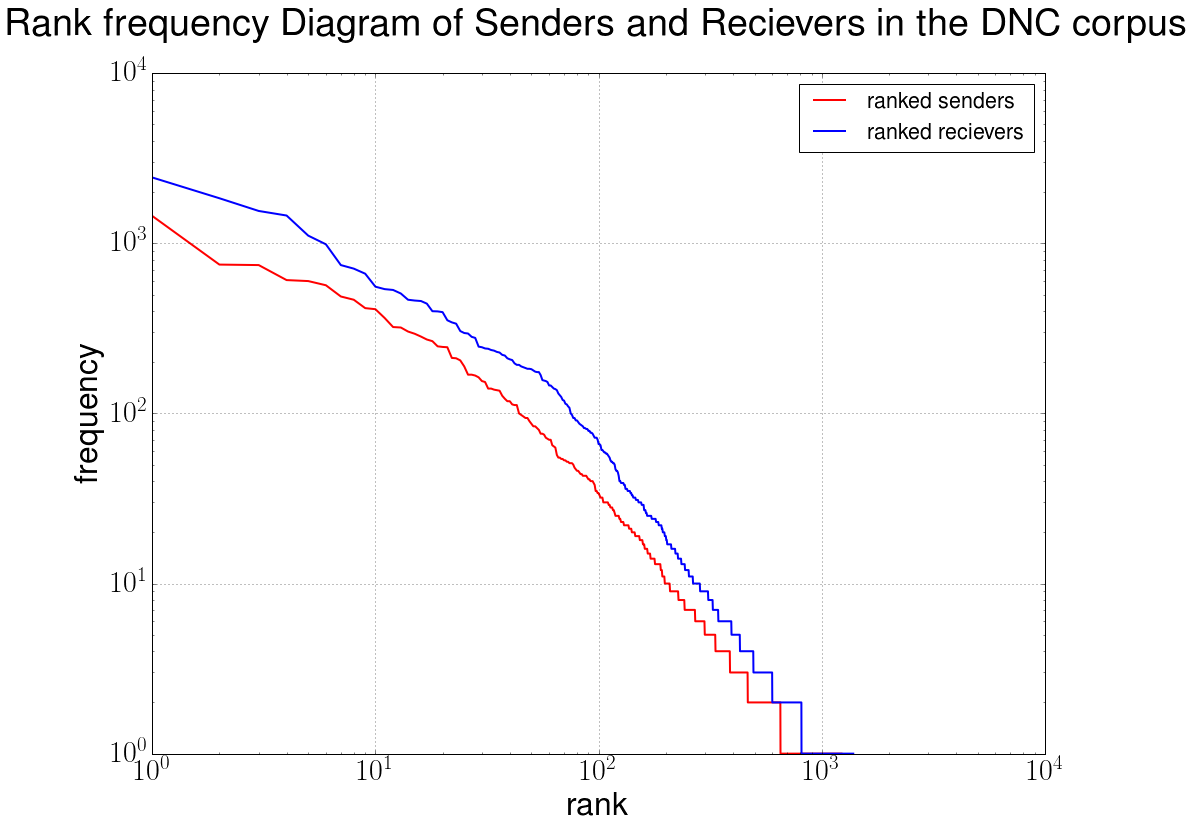

In [76]:
sCounts,tmp = zip(*d3_view)
rCounts,tmp= zip(*d2_view)
plt.plot(sCounts,"r-",label="ranked senders")
plt.plot(rCounts,"b-",label="ranked recievers")
plt.title("Rank frequency Diagram of Senders and Recievers in the DNC corpus",y=1.05)
plt.ylabel("frequency")
plt.xlabel("rank")
plt.xscale("log")
plt.yscale("log")
plt.legend( loc='upper right' )
plt.grid()
plt.show()

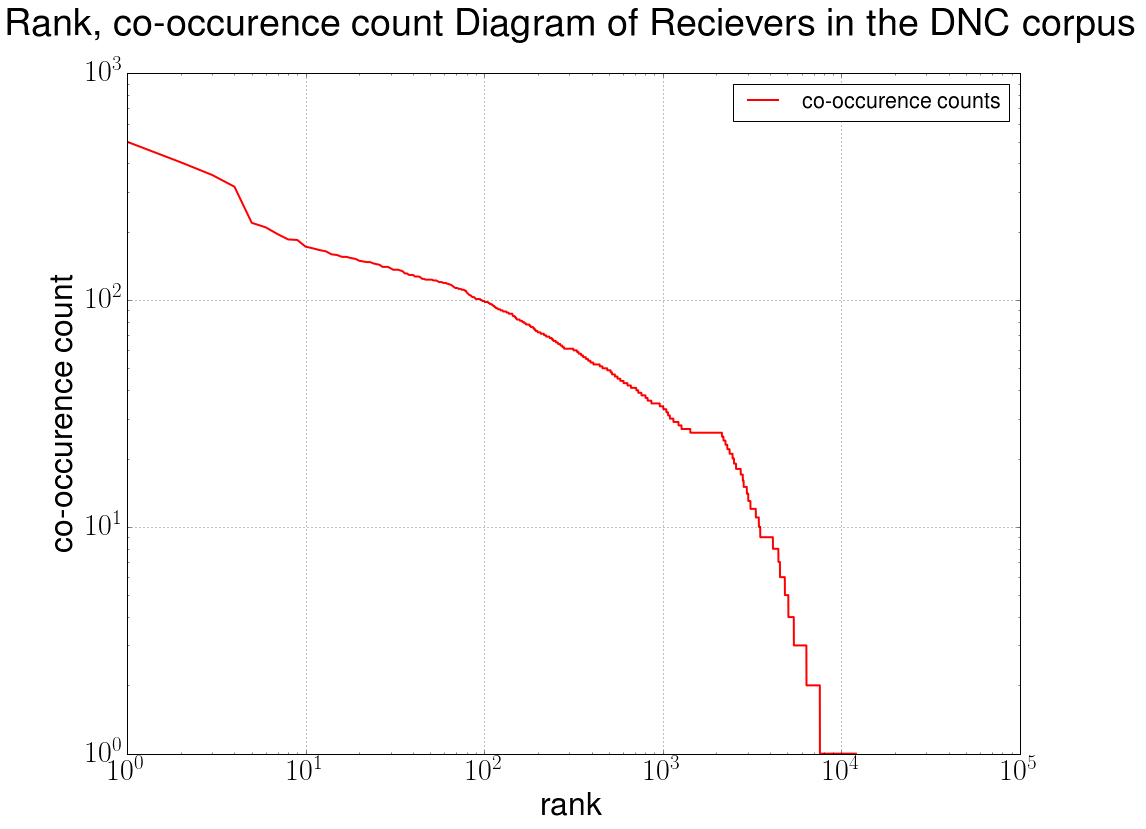

In [77]:
coocurrenceCounts,tmp = zip(*d_view)
plt.plot(coocurrenceCounts,"r-",label="co-occurence counts")
plt.title("Rank, co-occurence count Diagram of Recievers in the DNC corpus",y=1.05)
plt.ylabel("co-occurence count")
plt.xlabel("rank")
plt.xscale("log")
plt.yscale("log")
plt.legend( loc='upper right' )
plt.grid()
plt.show()